In [23]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import re
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from keras import backend as K


In [2]:
## Intent carregant les imatges en comptes d'utilitzar les rutes:

In [3]:

def load_images_and_masks(image_dir, mask_dir):
    images = []
    masks = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            # Cargar la imagen
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path).convert("RGB"))

            # Cargar la máscara correspondiente
            mask_filename = filename.replace(".png", "_mask.png")
            mask_path = os.path.join(mask_dir, mask_filename)

            try:
                mask = np.array(Image.open(mask_path).convert("L"))  # Convertir a escala de grises
                images.append(image)
                masks.append(mask)
            except FileNotFoundError:
                print(f"La máscara no encontrada para la imagen: {filename}")

    return np.array(images), np.array(masks)



In [4]:
# Directorios de imágenes y máscaras
#image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
#mask_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

image_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat'
mask_dir='/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT'

# image_dir="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat"
# mask_dir="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/Black Sea Sprat GT"

In [5]:
os.listdir(image_dir)

['00929.png',
 '00704.png',
 '00562.png',
 '00237.png',
 '00406.png',
 '00448.png',
 '00255.png',
 '00435.png',
 '00365.png',
 '00105.png',
 '00936.png',
 '00512.png',
 '00869.png',
 '00669.png',
 '00733.png',
 '00657.png',
 '00033.png',
 '00096.png',
 '00185.png',
 '00238.png',
 '00488.png',
 '00356.png',
 '00082.png',
 '00004.png',
 '00305.png',
 '00124.png',
 '00874.png',
 '00023.png',
 '00723.png',
 '00145.png',
 '00100.png',
 '00041.png',
 '00080.png',
 '00298.png',
 '00024.png',
 '00239.png',
 '00965.png',
 '00052.png',
 '00173.png',
 '00468.png',
 '00254.png',
 '00570.png',
 '00280.png',
 '00578.png',
 '00515.png',
 '00242.png',
 '00123.png',
 '00250.png',
 '00644.png',
 '00535.png',
 '00549.png',
 '00808.png',
 '00122.png',
 '00573.png',
 '00409.png',
 '00973.png',
 '00787.png',
 '00743.png',
 '00572.png',
 '00650.png',
 '00373.png',
 '00436.png',
 '00673.png',
 '00824.png',
 '00975.png',
 '00873.png',
 '00283.png',
 '00035.png',
 '00730.png',
 '00375.png',
 '00475.png',
 '0024

In [33]:
## Retallo les imatges per a que s'adequin al tamany necessari pel model.

image_list = []
resized_images = []

directory_path = image_dir

for filename in glob.glob(os.path.join(directory_path, '*.png')):
    print(filename)
    img = Image.open(filename)
    image_list.append(img)

for image in image_list:
    image = image.resize((590,444))
    resized_images.append(image)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
output_directory='/kaggle/working'
for (i, new) in enumerate(resized_images):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_image', i+1)))


/kaggle/working/resized_mask39.png
/kaggle/working/resized_mask877.png
/kaggle/working/resized_mask168.png
/kaggle/working/resized_image532.png
/kaggle/working/resized_mask390.png
/kaggle/working/resized_image277.png
/kaggle/working/resized_image445.png
/kaggle/working/resized_mask455.png
/kaggle/working/resized_mask279.png
/kaggle/working/resized_image16.png
/kaggle/working/resized_image454.png
/kaggle/working/resized_mask721.png
/kaggle/working/resized_image639.png
/kaggle/working/resized_image218.png
/kaggle/working/resized_mask290.png
/kaggle/working/resized_mask112.png
/kaggle/working/resized_mask83.png
/kaggle/working/resized_image312.png
/kaggle/working/resized_image516.png
/kaggle/working/resized_image480.png
/kaggle/working/resized_image144.png
/kaggle/working/resized_mask946.png
/kaggle/working/resized_image704.png
/kaggle/working/resized_image898.png
/kaggle/working/resized_mask222.png
/kaggle/working/resized_mask37.png
/kaggle/working/resized_mask188.png
/kaggle/working/res

In [36]:
## Retallo les mascares per a que s'adequin al tamany necessari pel model.
masks_list = []
resized_masks = []

directory_path = mask_dir

for filename in glob.glob(os.path.join(directory_path, '*.png')):
    print(filename)
    msk = Image.open(filename)
    masks_list.append(msk)

for mask in masks_list:
    mask = mask.resize((590,444))
    resized_masks.append(mask)

#output_directory = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
#output_directory ="/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
output_directory='/kaggle/working'

for (i, new) in enumerate(resized_masks):
    new.save(os.path.join(output_directory, '{}{}.png'.format('resized_mask', i+1)))



/kaggle/working/resized_image1435.png
/kaggle/working/resized_image1572.png
/kaggle/working/resized_mask39.png
/kaggle/working/resized_mask877.png
/kaggle/working/resized_mask168.png
/kaggle/working/resized_image532.png
/kaggle/working/resized_mask390.png
/kaggle/working/resized_image277.png
/kaggle/working/resized_image445.png
/kaggle/working/resized_mask455.png
/kaggle/working/resized_mask279.png
/kaggle/working/resized_image1750.png
/kaggle/working/resized_image16.png
/kaggle/working/resized_image454.png
/kaggle/working/resized_image1697.png
/kaggle/working/resized_mask721.png
/kaggle/working/resized_image639.png
/kaggle/working/resized_image218.png
/kaggle/working/resized_image1452.png
/kaggle/working/resized_mask290.png
/kaggle/working/resized_image1354.png
/kaggle/working/resized_mask112.png
/kaggle/working/resized_mask83.png
/kaggle/working/resized_image312.png
/kaggle/working/resized_image516.png
/kaggle/working/resized_image1736.png
/kaggle/working/resized_image480.png
/kaggle

In [37]:
#Carrego les imatges i mascares aparellades per no causar discordàncies a través d'un diccionaro

def load_images_and_masks(image_dir, mask_dir):
    # Creo el diccionari on guardaré les imatges
    data_dict = {}

    # Recorro els arxius del directori d'imatges
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            # Obtinc el numero d'imatge a partir del nom
            image_number = re.search(r'\d+', filename).group()

            # Carrego la imatge
            image_path = os.path.join(image_dir, filename)
            image = np.array(Image.open(image_path))

            # Carrego la mascara corresponent
            mask_filename = f"resized_mask{image_number}.png"
            mask_path = os.path.join(mask_dir, mask_filename)
            mask = np.array(Image.open(mask_path).convert("L"))
            
            #Normalitzo les mascares
            mask = mask.reshape(mask.shape[0], mask.shape[1], 1) / 255.0

            # Guardo la imatge i la mascara en un diccionari
            data_dict[image_number] = {'image': image, 'mask': mask}

    return data_dict

# Directori de les imatges i mascares (en el cas de kaggle és el mateix)
image_dir = '/kaggle/working'  # Cambia a tu directorio de imágenes
mask_dir = '/kaggle/working'   # Cambia a tu directorio de máscaras

# Carrego les imatges i mascares.
data_dict = load_images_and_masks(image_dir, mask_dir)

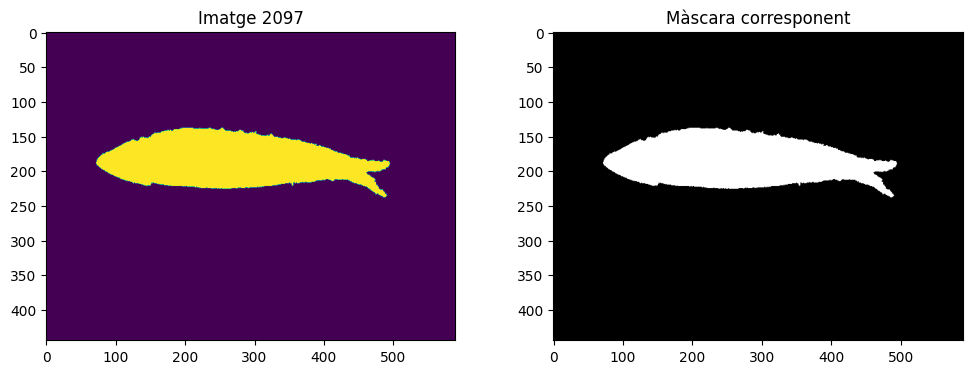

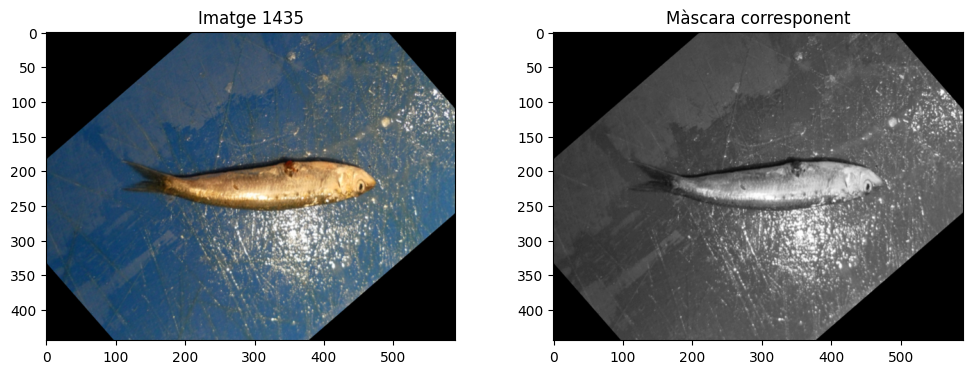

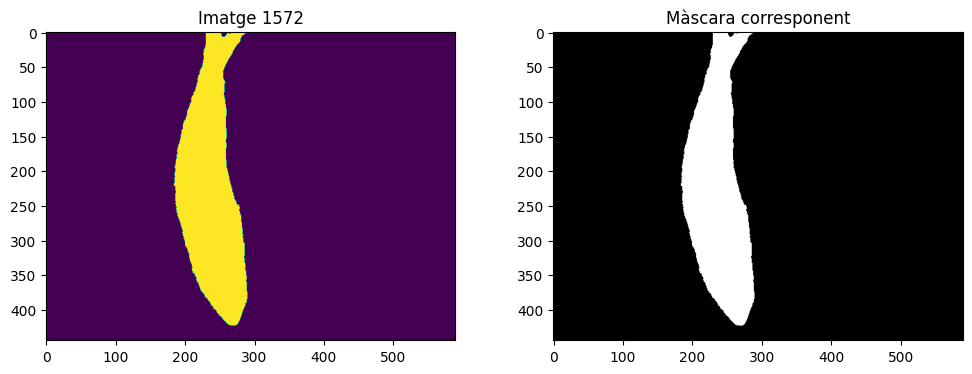

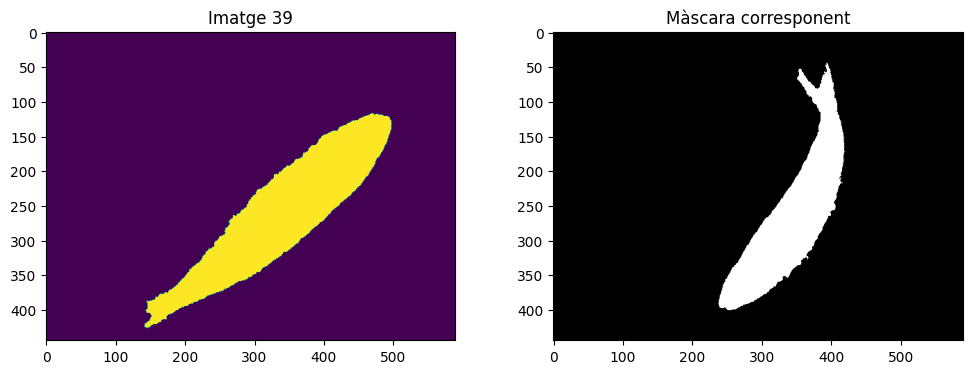

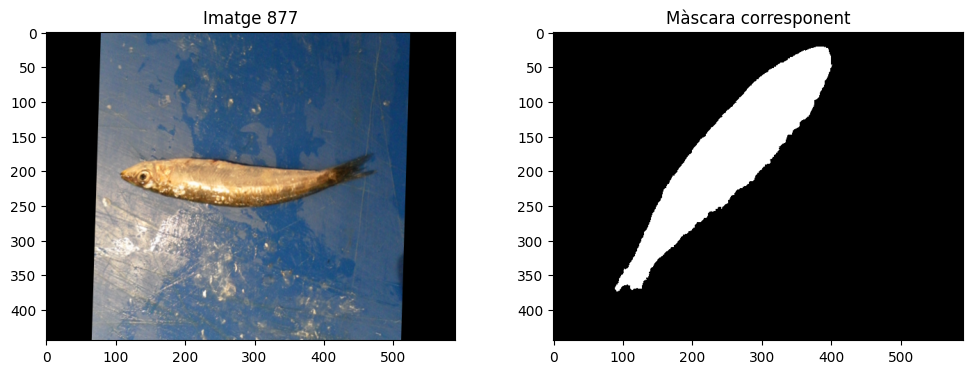

In [38]:
#Comprovo que s'hagin carregat aparellades agafant aleatoriament una mostra d'imatges i mascares.


sample_keys = list(data_dict.keys())[:5]  
for key in sample_keys:
    plt.figure(figsize=(12, 4))

    # Imatge original
    plt.subplot(1, 2, 1)
    plt.imshow(data_dict[key]['image'])
    plt.title(f'Imatge {key}')

    # Màscara
    plt.subplot(1, 2, 2)
    plt.imshow(data_dict[key]['mask'], cmap='gray')
    plt.title(f'Màscara corresponent')

    plt.show()

In [8]:
# def load_images(image_dir):
#     images = []

#     for filename in os.listdir(image_dir):
#         if filename.endswith(".png") and "image" in filename:
#             # Cargar la imagen
#             image_path = os.path.join(image_dir, filename)
#             image = np.array(Image.open(image_path).convert("RGB"))
#             normalized_image=image/255.0
#             images.append(normalized_image)

#     return np.array(images)



In [9]:
# # Ruta de les imatges
# #image_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_images/'
# #image_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_images"
# image_dir='/kaggle/working'


# # Carrego les imatges
# images = load_images(image_dir)

In [10]:
# def load_masks(mask_dir):
#     masks = []

#     for filename in os.listdir(mask_dir):
#         if filename.endswith(".png") and "mask" in filename:
#             # Cargar la máscara
#             mask_path = os.path.join(mask_dir, filename)
#             mask = np.array(Image.open(mask_path).convert("L"))
#             # Convertir a escala de grises
#             masks.append(mask)

#     return np.array(masks)



In [11]:
# # Ruta de les mascares
# #masks_dir = '/mnt/c/Users/enric/OneDrive - UAB/UNI Enric-portatil/4t/TFG/Propostes material/Fish dataset/Fish_Dataset/Fish_Dataset/Black Sea Sprat/resized_masks'
# #masks_dir = "/home/enric/Escritorio/uni portatil/TFG/Fish dataset/Fish_Dataset/Black Sea Sprat/resized_masks"
# masks_dir="/kaggle/working"


# # Carrego les imatges
# masks = load_masks(masks_dir)

In [12]:
# #Ajusto les imatges
# #adjusted_images = images.reshape(-1, 590, 444, 3)

# masks = masks.reshape(-1, masks.shape[1], masks.shape[2], 1)
# masks=masks/255.0

In [39]:
#images.shape

first_image_shape = data_dict[sample_keys[0]]['image'].shape


print("Dimensions de la primera imatge:", first_image_shape)


Dimensions de la primera imatge: (444, 590)


In [40]:
#masks.shape

first_mask_shape = data_dict[sample_keys[1]]['mask'].shape


print("Dimensions de la primera mascara:", first_mask_shape)

Dimensions de la primera mascara: (444, 590, 1)


In [41]:
# def dice_coeff(y_true, y_pred):
#     smooth = 1.
#     # Flatten
#     y_true_f = tf.reshape(y_true, [-1])
#     y_pred_f = tf.reshape(y_pred, [-1])
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
#     return score


# def dice_loss(y_true, y_pred):
#     loss = 1 - dice_coeff(y_true, y_pred)
#     return loss

# def bce_dice_loss(y_true, y_pred):
#     loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
#     return loss



def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [16]:
# Construye el modelo
input_shape = (444,590, 3)
num_filters = 32


## Model més simple per miar de solventar el problema de dimensions.
model = models.Sequential()
    
# Encoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
    
# Decoder
model.add(layers.Conv2D(num_filters, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.UpSampling2D((2, 2)))
model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

# Compile the model
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef]) #dice coefficient



In [17]:
# Train the model
model.fit(images, masks, epochs=10, batch_size=8)


Epoch 1/10
125/125 [==============================] - 22s 85ms/step - loss: -0.2823 - dice_coef: 0.2823
Epoch 2/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3201 - dice_coef: 0.3201
Epoch 3/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3292 - dice_coef: 0.3292
Epoch 4/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3317 - dice_coef: 0.3317
Epoch 5/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3345 - dice_coef: 0.3345
Epoch 6/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3368 - dice_coef: 0.3368
Epoch 7/10
125/125 [==============================] - 11s 86ms/step - loss: -0.3382 - dice_coef: 0.3382
Epoch 8/10
125/125 [==============================] - 11s 87ms/step - loss: -0.3404 - dice_coef: 0.3404
Epoch 9/10
125/125 [==============================] - 11s 87ms/step - loss: -0.3404 - dice_coef: 0.3404
Epoch 10/10
125/125 [==============================] - 11s 87ms/

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 444, 590, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 444, 590, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 444, 590, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 222, 295, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 295, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 222, 295, 32)      1

1/1 [==============================] - 0s 29ms/step


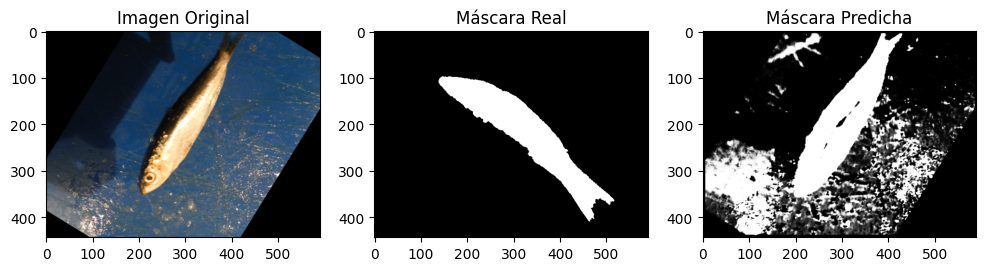

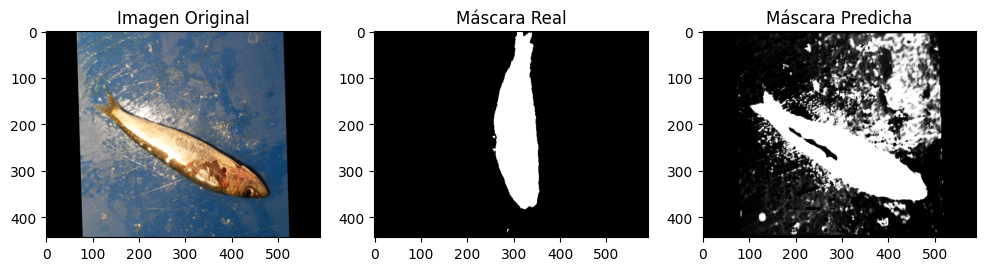

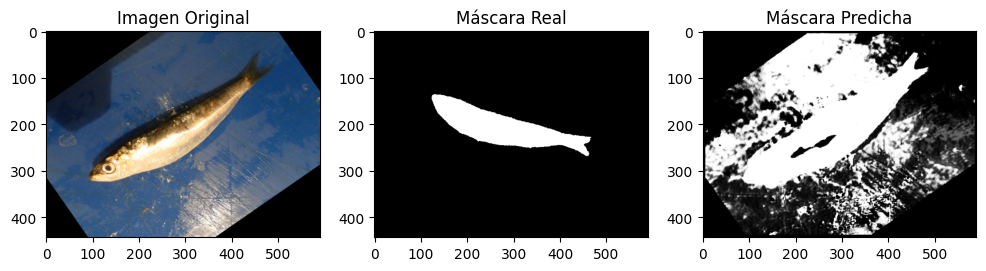

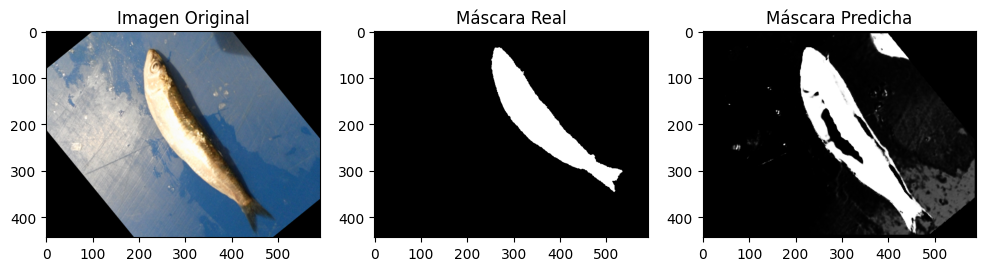

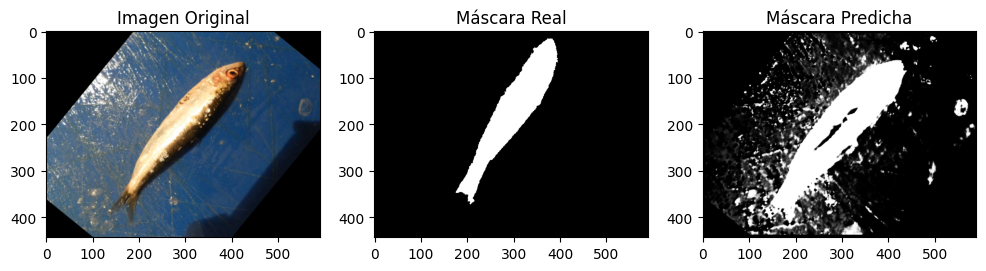

In [20]:
#comprovo com funciona el model
num_samples = 5
sample_indices = random.sample(range(len(images)), num_samples)
sample_images = [images[i] for i in sample_indices]
sample_masks_true = [masks[i] for i in sample_indices]


sample_masks_pred = model.predict(np.array(sample_images))


for i in range(num_samples):
    plt.figure(figsize=(12, 4))

    
    plt.subplot(1, 3, 1)
    plt.imshow(sample_images[i])
    plt.title('Imatge original')

   
    plt.subplot(1, 3, 2)
    plt.imshow(sample_masks_true[i][:, :, 0], cmap='gray')  
    plt.title('Màscara real)

    
    plt.subplot(1, 3, 3)
    plt.imshow(sample_masks_pred[i][:, :, 0], cmap='gray')  
    plt.title('Predicció')

    plt.show()


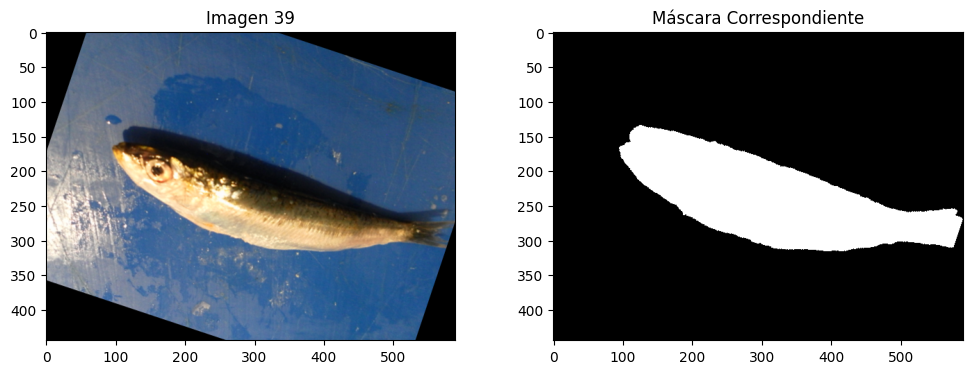

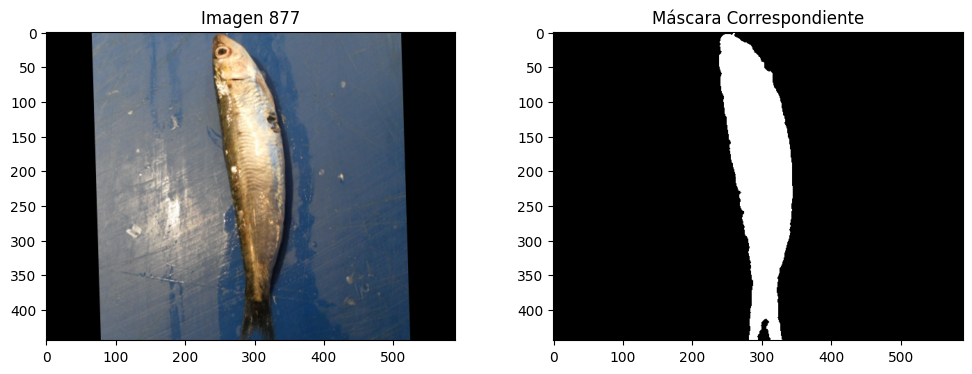

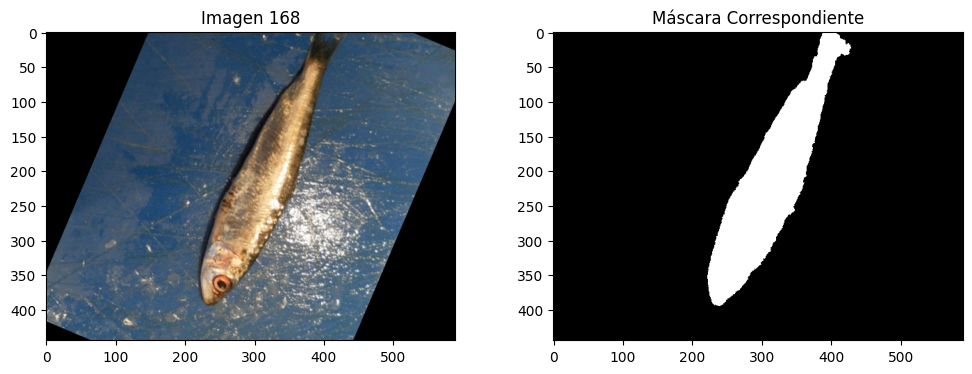

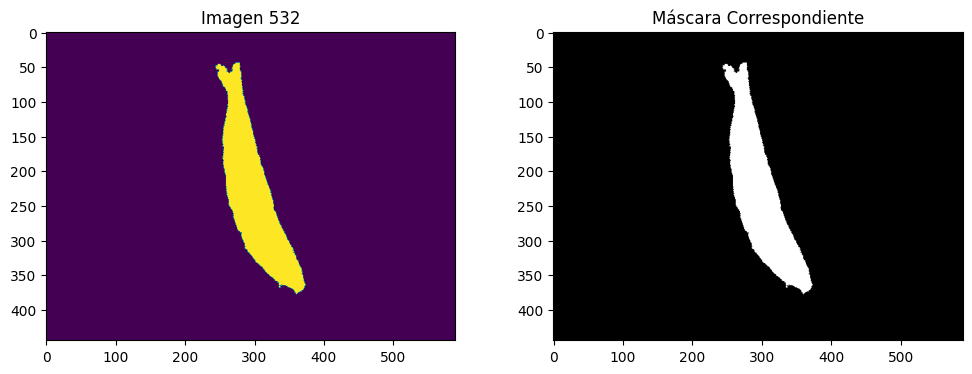

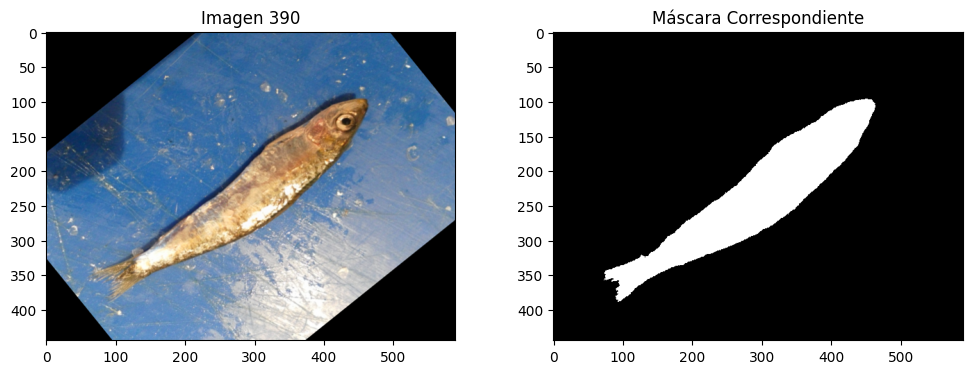